## Simulate handwritten digits simulation with trained DNNAE and GMM

In [1]:
# Copyright (C) 2018 Zhixian MA <zx@mazhixian.me>

In [2]:
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf

In [4]:
from dnnae.dnn import dnn
from dnnae.utils import utils

/home/mzx/.local/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
from dnnae.configs import config_mnist_bn
from dnnae.configs import config_train

### Load mnist data

In [6]:
# Step1 load MNITST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=False, validation_size=5000)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [7]:
cf = config_mnist_bn
tr_cf = config_train

### Build the net

In [8]:
net = dnn(cf)
net.dnn_build()
# print the net structure
net.dnn_print()

Layer ID    Layer type    Layer shape
0 Input layer [None, 784]
1 FC layer 0 [None, 256]
2 BN layer 0 [None, 256]
3 FC layer 1 [None, 128]
4 BN layer 1 [None, 128]
5 Softmax layer [None, 10]
6 Encoder layer [None, 32]
7 FC layer 1 [None, 128]
8 BN layer 1 [None, 128]
9 FC layer 0 [None, 256]
10 BN layer 0 [None, 256]
11 Output layer [None, 784]


### Restore the net

In [9]:
net.get_learning_rate()
net.get_loss()
net.get_accuracy()
net.get_opt_mse()
net.get_opt_ce()

# load the net
import os
foldname = "./dnnae_mnist"
name = 'dnnae.pkl'
net.sess, name = utils.load_net(os.path.join(foldname, name))

INFO:tensorflow:Restoring parameters from ./dnnae_mnist/model_dnnae.ckpt


### Construct GMM model

In [14]:
# Get code: batchly
import numpy as np
labels = mnist.train.labels
idx = np.where(labels == 8)[0]

code = np.zeros((len(idx), cf.layers[-1]))
batchsize = tr_cf.batchsize
numbatch = len(idx) // batchsize

x_data = mnist.train.images
for i in range(numbatch):
    code[i*batchsize: (i+1)*batchsize] = utils.get_feature(
        net=net,data=x_data[idx[i*batchsize:(i+1)*batchsize]])

In [15]:
# FRI
gmm = utils.getGMM(data=code, n_components=11, covariance_type='full')

In [16]:
# simulate 10 samples
rs = cf.rs
code_sim = gmm.sample(n_samples=10)[0]
img_sim = net.sess.run(
    net.outputs_de, 
    feed_dict={net.inputs: np.zeros((10,rs*rs)), 
               net.code: code_sim, 
               net.is_training: False})

/home/mzx/.local/lib/python3.5/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


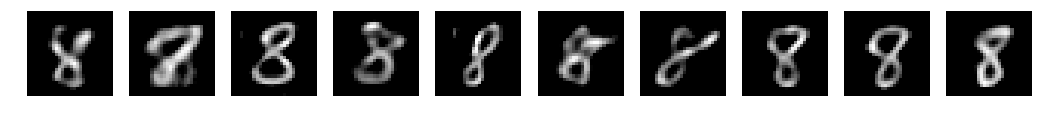

In [17]:
# plot result
plt.rcParams["figure.figsize"] = [18.0, 3.0]
n_examples = 10
fig, axs = plt.subplots(1, n_examples)
for example_i in range(n_examples):
    # raw
    axs[example_i].imshow(np.reshape(img_sim[example_i, :], (rs, rs)), cmap='gray')
    axs[example_i].axis('off')

fig.show()
plt.draw()